In [1]:
from autoencodeSVJ import utils, models, trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

SEED = 42

Using TensorFlow backend.


### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

background tags:

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%

signal tags:

down jet: 1220, 2.5%
up jet: 1866, 3.8%
strange jet: 1550, 3.1%
charm jet: 3344, 6.8%
bottom jet: 38995, 78.8%
gluon jet: 2541, 5.1%

data_table :: plotting distrubution(s) for table(s) ['signal', 'background']


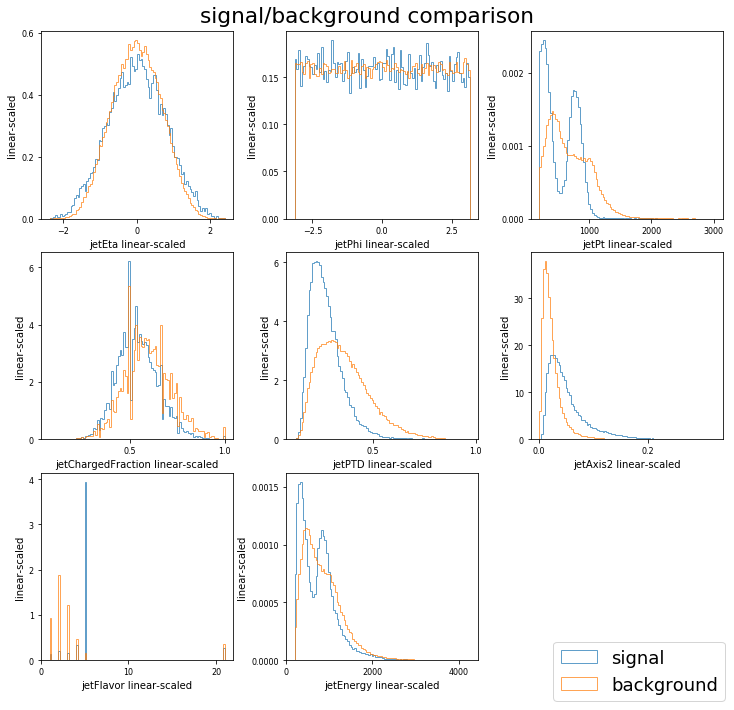

In [5]:
dcols = ["jetM", "*MET*", "*Delta*"]
background, _, _ = utils.load_all_data("data/tightSVJ/20h5/*.h5", "background", cols_to_drop=dcols)
signal, _, _ = utils.load_all_data("data/signal/fullh5/*.h5", "signal", cols_to_drop=dcols)

signal.plot(background, normed=1, figname="signal/background comparison", cols=3, figsize=10, bins=100)

In [30]:
print "data tags:"
print "" 
tagged_data, tag_index_data = utils.split_by_tag(data)
print ""
print "signal tags:"
print ""
tagged_signal, tag_index_signal = utils.split_by_tag(signal)

data tags:

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%

signal tags:

down jet: 1220, 2.5%
up jet: 1866, 3.8%
strange jet: 1550, 3.1%
charm jet: 3344, 6.8%
bottom jet: 38995, 78.8%
gluon jet: 2541, 5.1%


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

In [4]:
split = 0.4
train, test = data.train_test_split(split, SEED)
utils.compare_tags([data, signal] + list(data.train_test_split(0.4)))

bottom:
	3.2% (3341) all jet data
	78.8% (38995) signal
	3.2% (1986) train
	3.3% (1355) test
up:
	37.6% (38841) all jet data
	3.8% (1866) signal
	37.8% (23432) train
	37.2% (15409) test
down:
	18.4% (18999) all jet data
	2.5% (1220) signal
	18.3% (11364) train
	18.5% (7635) test
strange:
	24.5% (25377) all jet data
	3.1% (1550) signal
	24.5% (15216) train
	24.6% (10161) test
charm:
	9.3% (9577) all jet data
	6.8% (3344) signal
	9.2% (5694) train
	9.4% (3883) test
gluon:
	7.0% (7281) all jet data
	5.1% (2541) signal
	7.0% (4357) train
	7.1% (2924) test


data_table :: plotting distrubution(s) for table(s) ['signal', 'all jet data']


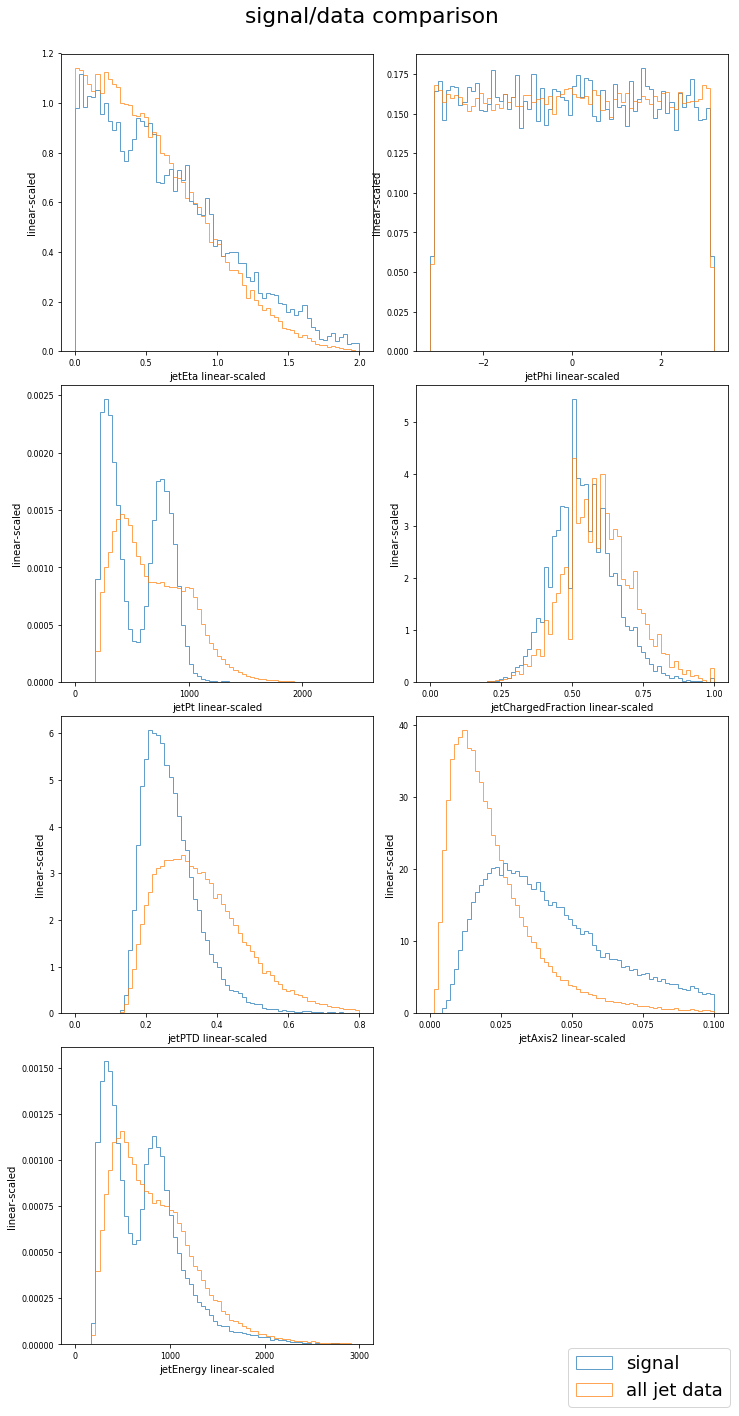

In [5]:
signal.cdrop("jetFlavor").plot(data, normed=1, bins=70, cols=2, figsize=(10,20), rng=(
        (0,2), (-3.2, 3.2), (0,2500), (0,1), (0, 0.8),(0,.1), (0,3000)), figname="signal/data comparison")

We then get training/testing datasets, and normalize them to the main data set. We can check how the normalized features look compared with one another, to make sure that they are useful. This way we can decide what type of normalization to use.

In [7]:
data_raw = data.cdrop("*Flavor")
signal_raw = signal.cdrop("*Flavor")

norm_args = {
    "norm_type": "StandardScaler",
#     "feature_range": (0.01, 0.99)
}

data_norm = data_raw.norm(**norm_args)
signal_norm = data_raw.norm(signal_raw, **norm_args)

# features = [utils.data_table(norm[c].values.reshape(data_norm[c].shape[0],1), name=c, headers=["normed features"]) for c in norm]
# features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10, figloc="center right", figname="Scaled Features")

# rmin, rmax = np.asarray([(data.median() - 2.*data.std()).values, (data.median() + 2.*data.std()).values])
# custom_norm = lambda x: (x - rmin) / (rmax - rmin)
# # norm_data = data.norm(norm_type=0, rng=rng)
# norm_data = custom_norm(data)
# features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
# features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

we will use `RobustScaler`, because the results look the best (and train the best ;-))

### 2. load/train model
we can load a model that we've already trained, because we just want to evaluate results.

In [12]:
rel_path = "autoencode/data/training_runs/7jf/custom/bn_5_v4"
path = os.path.join(repo_head, rel_path)

instance = trainer.trainer(path)
autoencoder = instance.load_model()
encoder, decoder = autoencoder.layers[1:]

h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'bn_5_v4.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'bn_5_v4.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'bn_5_v4.h5'
h5_elt 'val_r_square' :: loading dataset 'metric_names/val_r_square' from file 'bn_5_v4.h5'
h5_elt 'loss' :: loading dataset 'metric_names/loss' from file 'bn_5_v4.h5'
h5_elt 'mean_absolute_error' :: loading dataset 'metric_names/mean_absolute_error' from file 'bn_5_v4.h5'
h5_elt 'val_mean_squared_error' :: loading dataset 'metric_names/val_mean_squared_error' from file 'bn_5_v4.h5'
h5_elt 'val_mean_absolute_error' :: loading dataset 'metric_names/val_mean_absolute_error' from file 'bn_5_v4.h5'
h5_elt 'r_square' :: loading dataset 'metric_names/r_square' from file 'bn_5_v4.h5'
h5_elt 'mean_squared_error' :: loading dataset 'metric_names/mean_squared_error' from file 'bn_5_v4.h5'
h5_elt 'lr' :: loading dataset 'metric_names/lr' from file 'bn_5_v4.h5'
h5_e

... and the model summaries:

In [13]:
# print('encoder summary:')
# encoder.summary()
# print('\n')
# print('decoder summary:')
# decoder.summary()
# print('\n')
print('autoencoder summary:')
autoencoder.summary()


autoencoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
encoder (Model)              (None, 5)                 525       
_________________________________________________________________
decoder (Model)              (None, 7)                 527       
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________


### 3. evaluate signal and data errors


In [17]:
def get_recon_errors(data_list, autoencoder, **kwargs):

    if not isinstance(data_list, list):
        data_list = [data_list]
    
    recon = []
    errors = []
    
    for i,d in enumerate(data_list):
        recon.append(
            utils.data_table(
                autoencoder.predict(d.data),        
                headers=d.headers,
                name="{0} pred".format(d.name)
            )
        )
        errors.append(
            utils.get_errors(recon[i].data, d.data, out_name="{0} error".format(d.name), **kwargs)
        )
        
    return errors, recon

def roc_auc_plot(data_err, signal_err):
    from sklearn.metrics import roc_curve, roc_auc_score
    pred = np.hstack([signal_err['mae'].values, data_err['mae'].values])
    true = np.hstack([np.ones(signal_err.shape[0]), np.zeros(data_err.shape[0])])

    roc = roc_curve(true, pred)
    auc = roc_auc_score(true, pred)
    print "auc value:", auc
    plt.figure(figsize=(10,10))
    # ax = fig.axes() 
    plt.plot(roc[0], roc[1])
    plt.plot((0,1), (0,1))
    plt.show()
    
    return {"roc": roc, "auc": auc}
    
tagged_norm = [data_raw.norm(t, **norm_args) for t in tagged_data]

errors, recon = get_recon_errors([signal_norm, data_norm] + tagged_norm, autoencoder)

# data_recon = data_raw.inorm(data_norm_recon, **norm_args)
# signal_recon = signal_raw.inorm(signal_norm_recon, **norm_args)

# signal_recon.name = "pred signal"
# data_recon.name = "pred data"

auc value: 0.567492847668


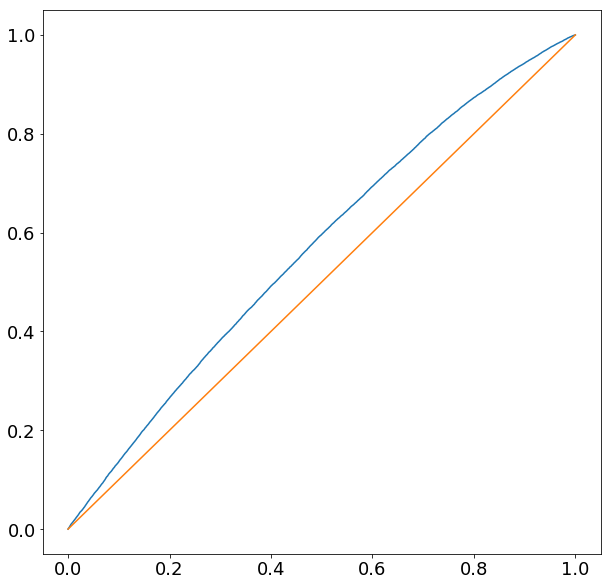

{'auc': 0.56749284766803354,
 'roc': (array([  0.00000000e+00,   0.00000000e+00,   9.66968361e-06, ...,
           9.99990330e-01,   9.99990330e-01,   1.00000000e+00]),
  array([  2.01954924e-05,   8.07819695e-05,   8.07819695e-05, ...,
           9.99979805e-01,   1.00000000e+00,   1.00000000e+00]),
  array([ 0.58107222,  0.52503986,  0.51070813, ...,  0.00165366,
          0.00160699,  0.00130544]))}

In [25]:
roc_auc_plot(errors[1], errors[0])


In [6]:
signal_errors.plot(data_errors, normed=1, bins=50, rng=((.4, .7), (0, 0.4)),figname="signal vs data errors")

NameError: name 'signal_errors' is not defined

"'down' normed to 'all jet data' error"

In [98]:
from sklearn.metrics import roc_curve, roc_auc_score

pred = np.hstack([signal_errors['mae'].values, data_errors['mae'].values])
true = np.hstack([np.ones(signal_errors.shape[0]), np.zeros(data_errors.shape[0])])

roc = roc_curve(true, pred)
auc = roc_auc_score(true, pred)
print auc

0.622255972626


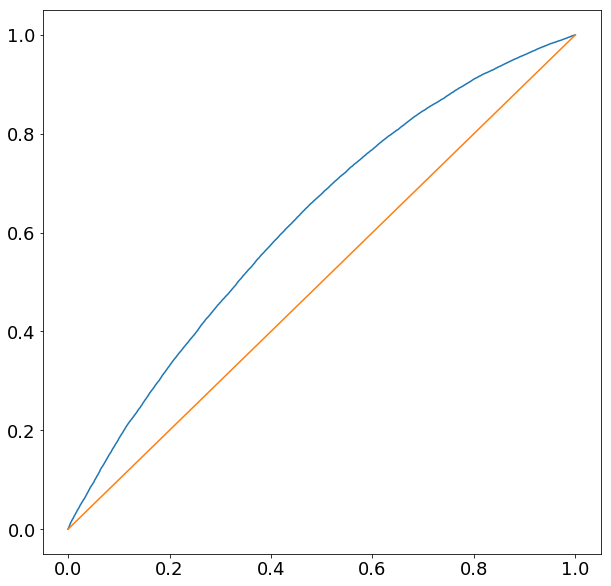

In [97]:
plt.figure(figsize=(10,10))
# ax = fig.axes() 
plt.plot(roc[0], roc[1])
plt.plot((0,1), (0,1))
plt.show()

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'pred data', 'signal', 'pred signal']


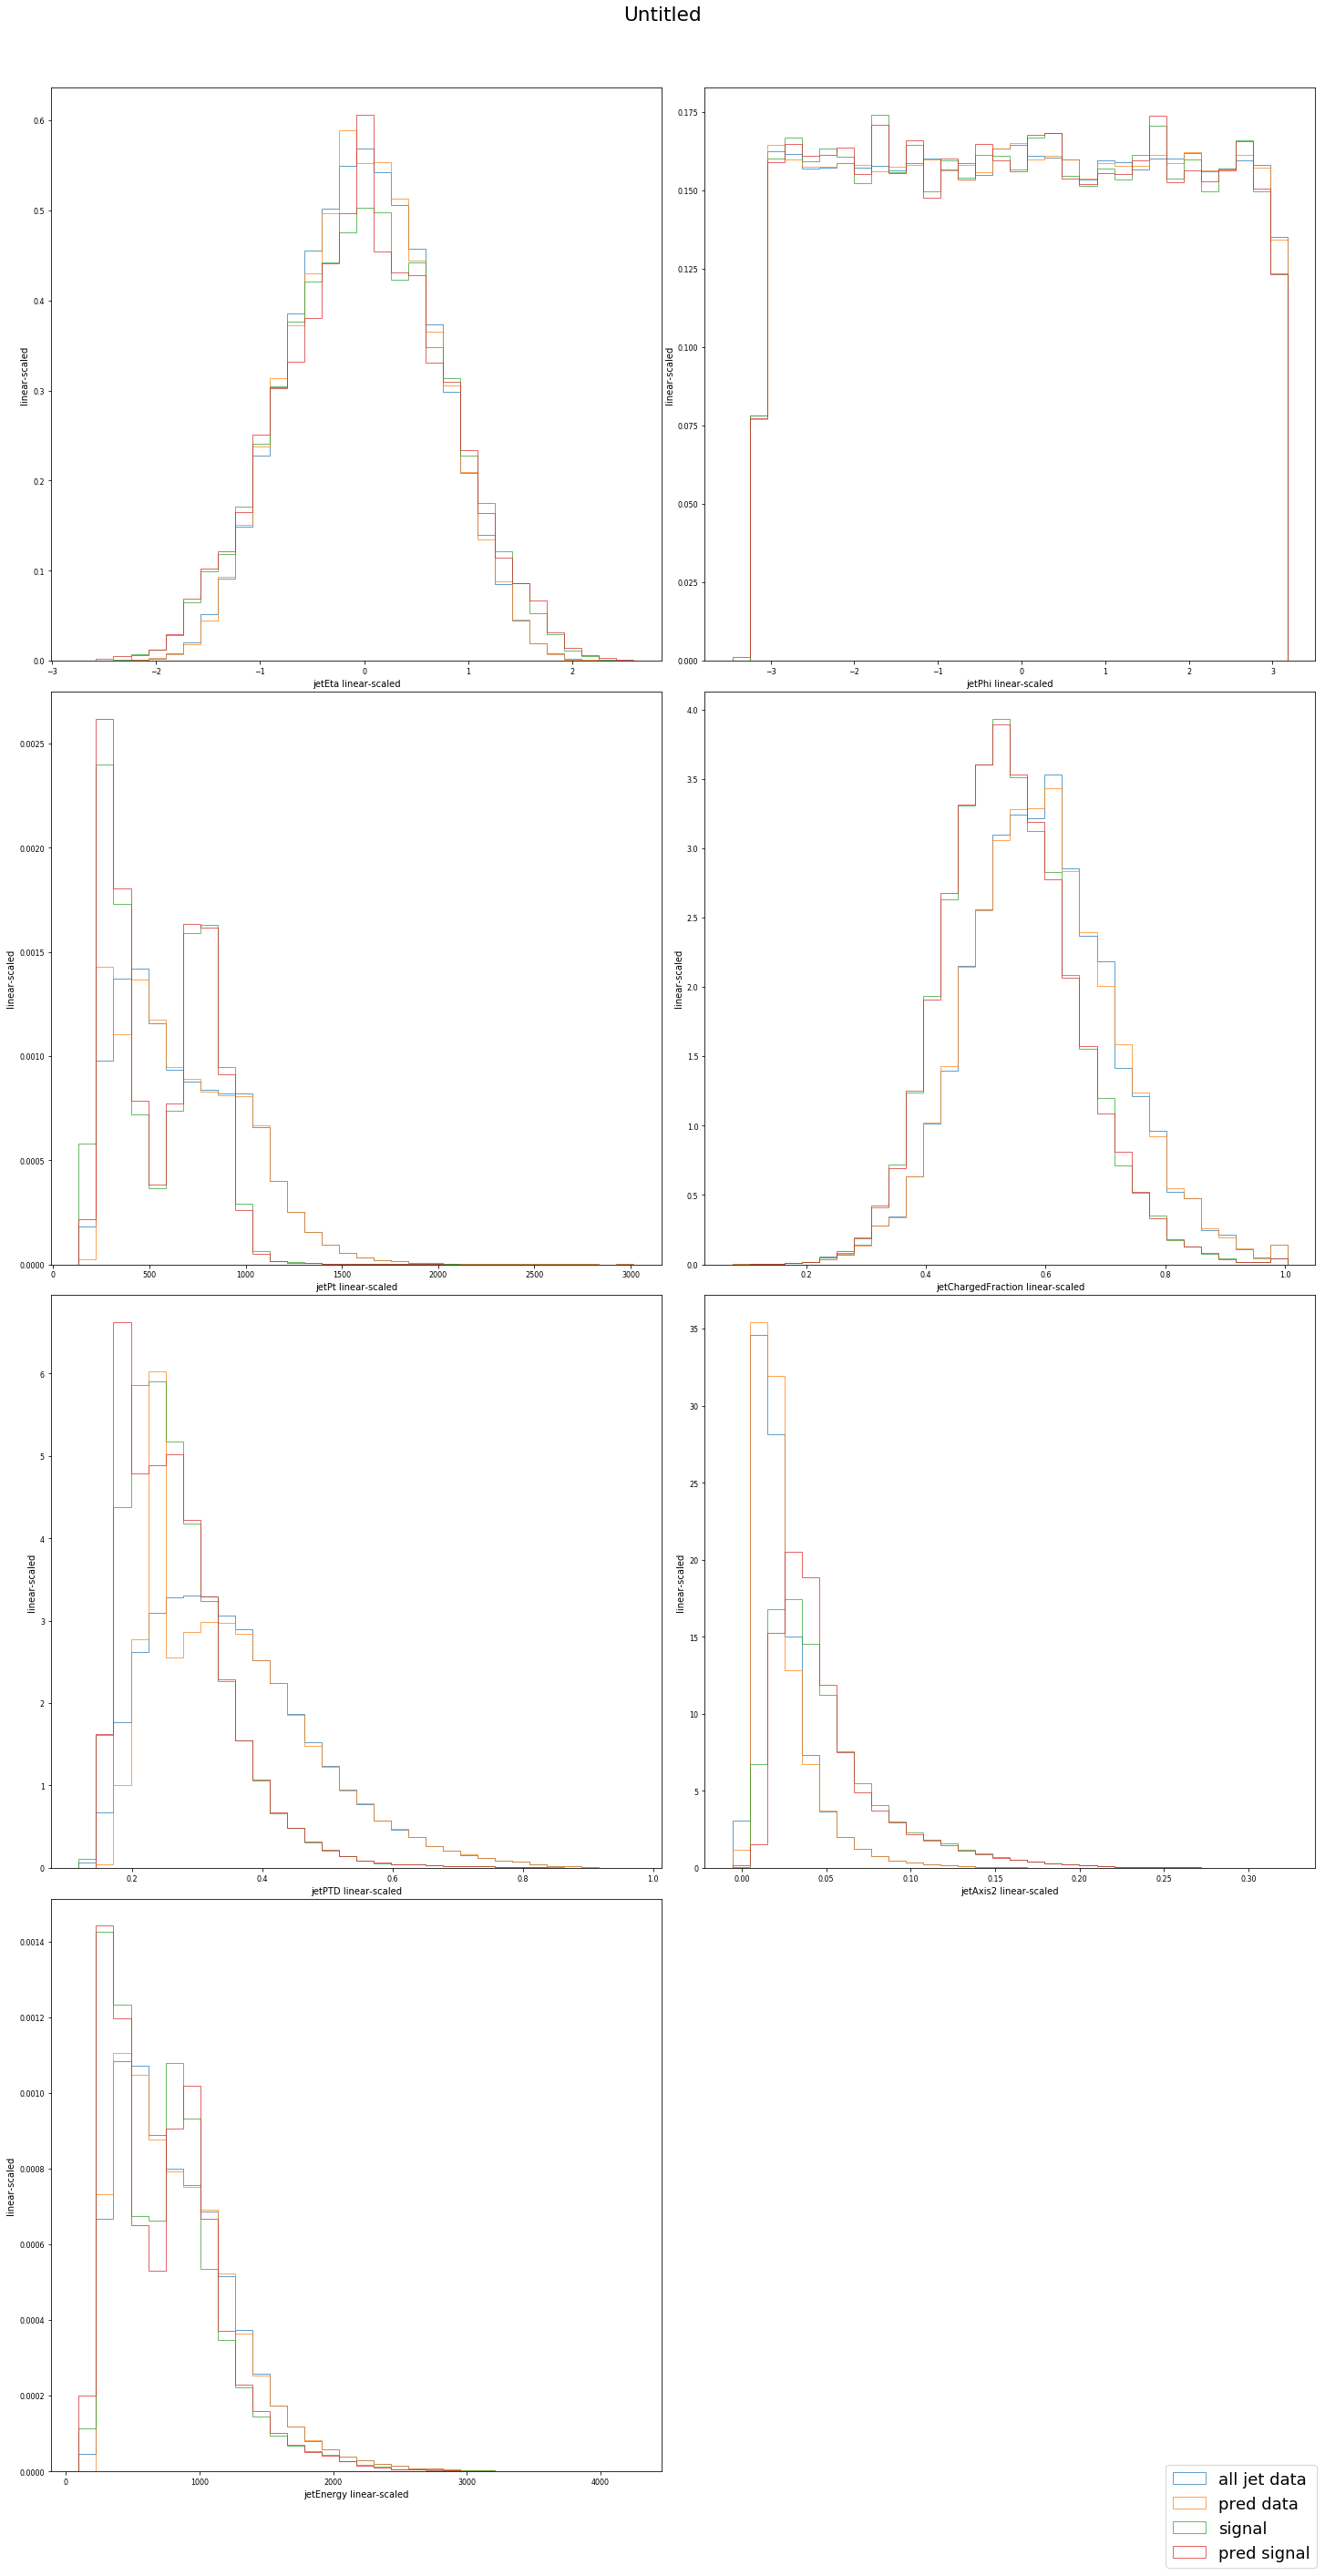

In [47]:
data_raw.plot([data_recon, signal_raw, signal_recon], normed=1, cols=2, figsize=(20,40))

training is easy:

In [18]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred), axis=-1)
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)), axis=-1)
    return SS_res/SS_tot

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

autoencoder = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss='mse',
    epochs=50,
    model=autoencoder,
    metrics=[r_square, "mae", "mse"],
    force=True,
    batch_size=128,
    use_callbacks=True,
    learning_rate=0.001
)

Train on 87903 samples, validate on 15513 samples
Epoch 1/50
686/686 [==============================] - 106s 154ms/step - loss: 0.0253 - r_square: 0.9747 - mean_absolute_error: 0.1039 - mean_squared_error: 0.0253 - val_loss: 0.0133 - val_r_square: 0.9867 - val_mean_absolute_error: 0.0712 - val_mean_squared_error: 0.0133
Epoch 2/50
686/686 [==============================] - 106s 155ms/step - loss: 0.0118 - r_square: 0.9882 - mean_absolute_error: 0.0645 - mean_squared_error: 0.0118 - val_loss: 0.0114 - val_r_square: 0.9885 - val_mean_absolute_error: 0.0610 - val_mean_squared_error: 0.0114
Epoch 3/50
686/686 [==============================] - 103s 150ms/step - loss: 0.0109 - r_square: 0.9891 - mean_absolute_error: 0.0592 - mean_squared_error: 0.0109 - val_loss: 0.0109 - val_r_square: 0.9891 - val_mean_absolute_error: 0.0579 - val_mean_squared_error: 0.0109
Epoch 4/50
686/686 [==============================] - 119s 174ms/step - loss: 0.0105 - r_square: 0.9895 - mean_absolute_error: 0.0572 

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

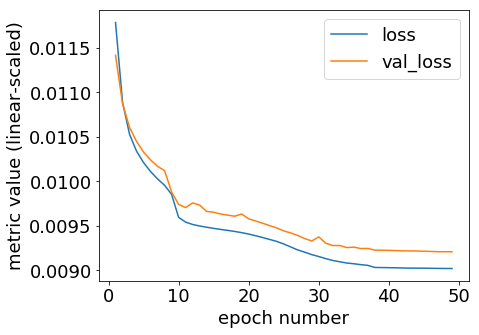

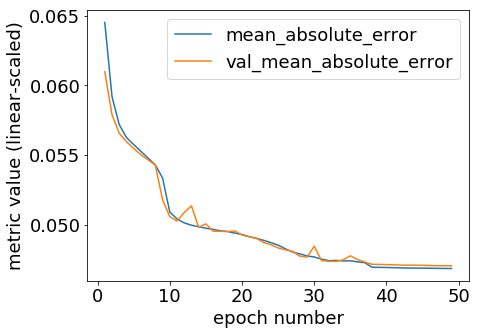

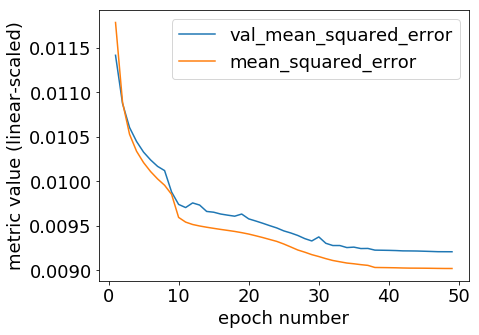

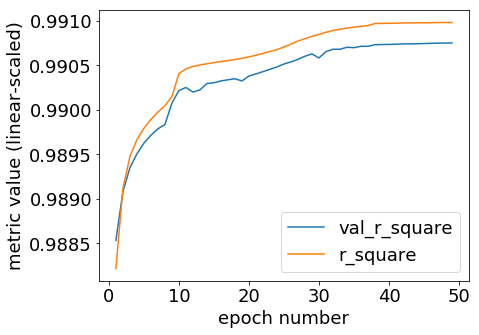

In [20]:
instance.plot_metrics(fnmatch_criteria="*loss*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*squared*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


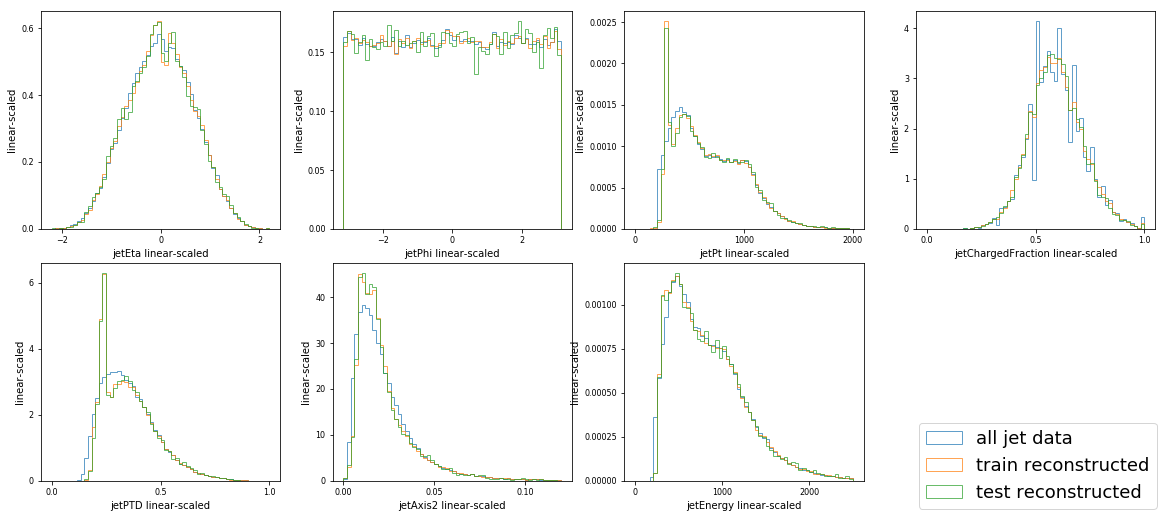

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


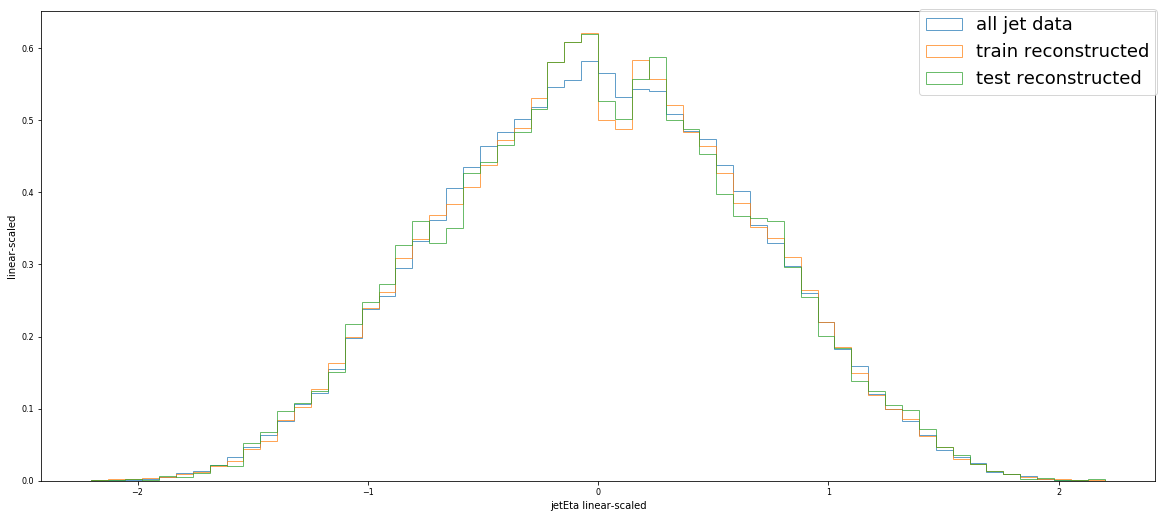

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


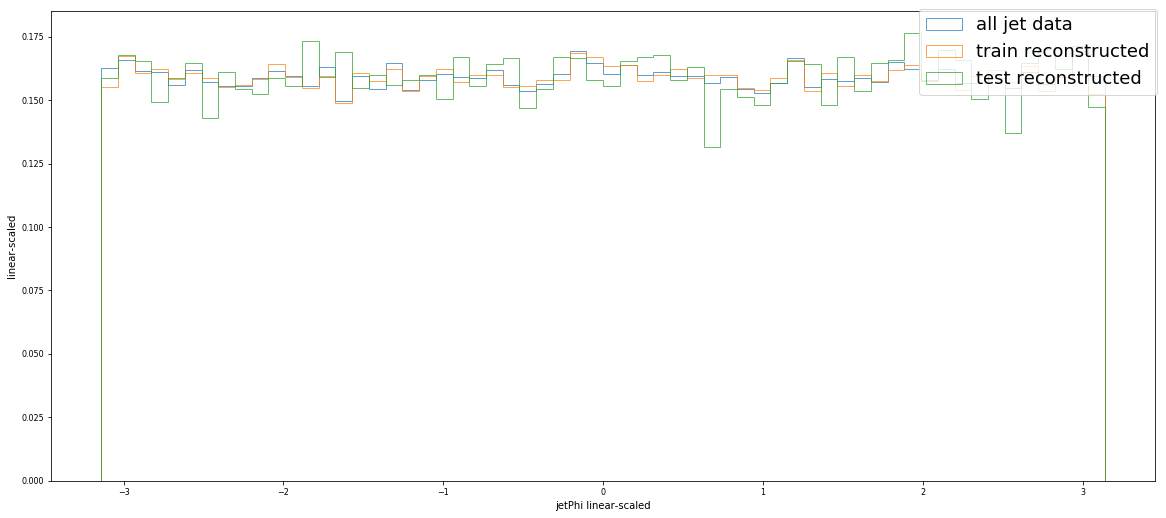

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


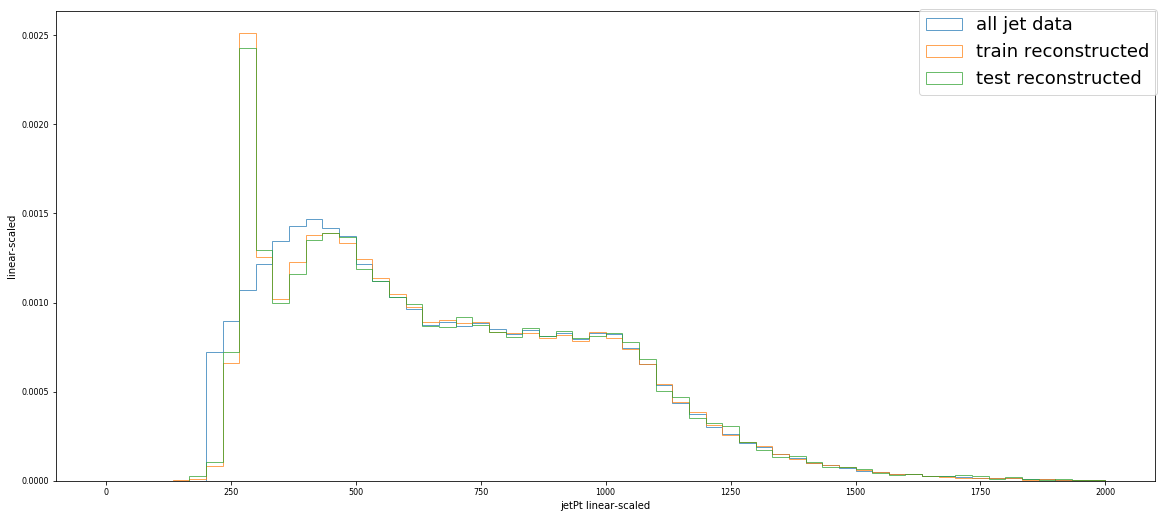

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


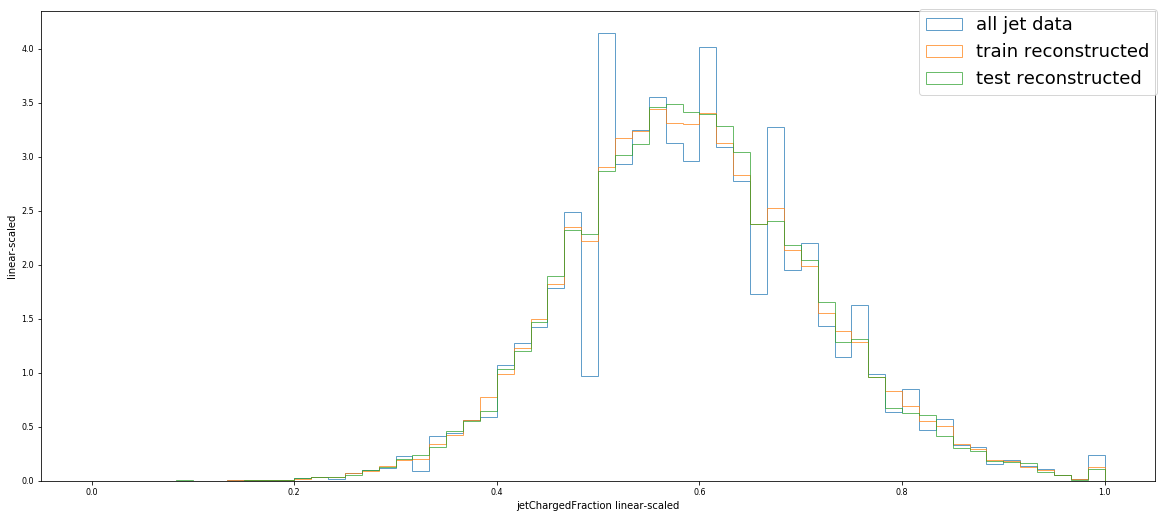

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


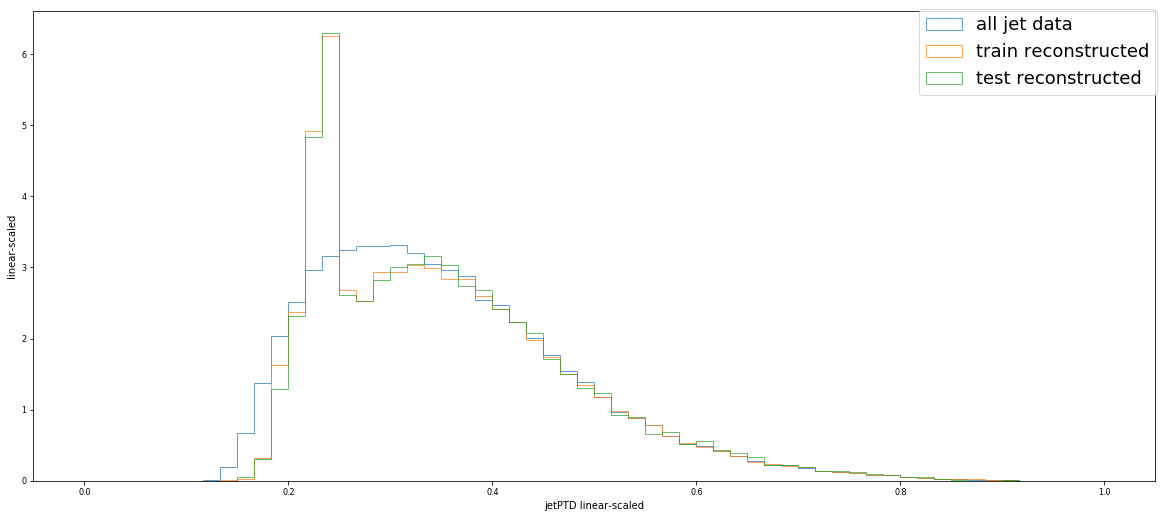

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


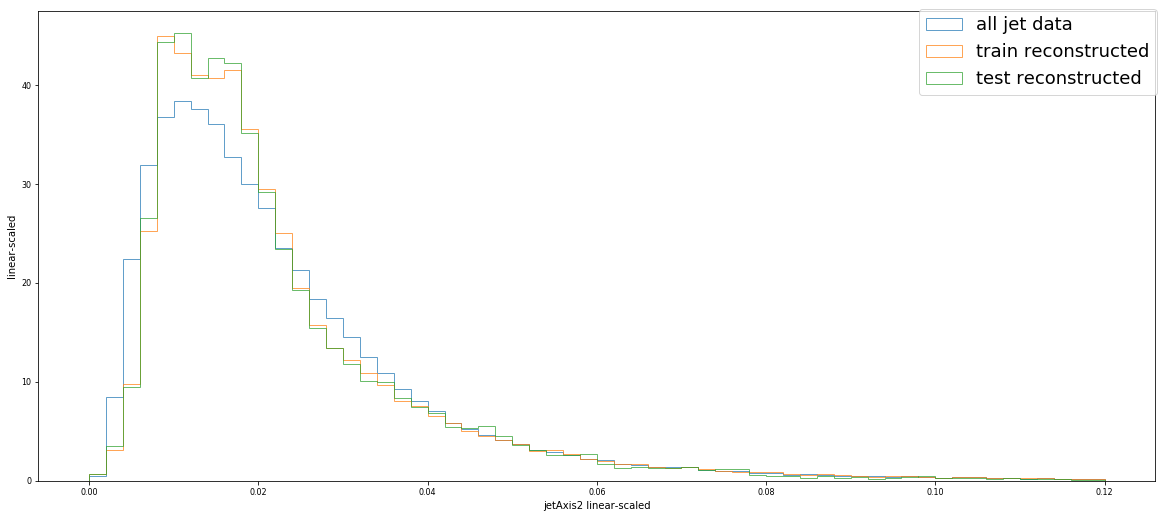

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


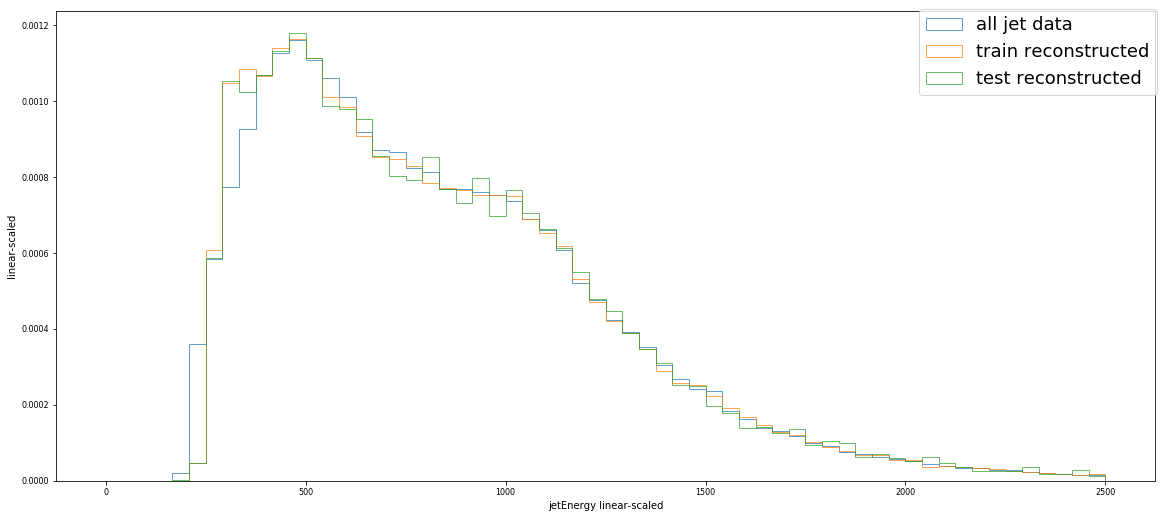

In [21]:

# data_recon_norm = utils.data_table(autoencoder.predict(.norm(**norm_args).df.values), headers=train_norm.headers)
# data_recon = data.inorm(data_recon_norm, **norm_args)
# data_recon.name = "all jet data (pred)"

train_reconstructed_norm = utils.data_table(autoencoder.predict(train_norm.data), headers=train_norm.headers)
test_reconstructed_norm = utils.data_table(autoencoder.predict(test_norm.data), headers=test_norm.headers)
data_reconstructed_norm = utils.data_table(autoencoder.predict(norm.data), headers=norm.headers)

train_reconstructed = train_raw.inorm(train_reconstructed_norm, **norm_args)
test_reconstructed = train_raw.inorm(test_reconstructed_norm, **norm_args)
data_reconstructed = train_raw.inorm(data_reconstructed_norm, **norm_args)

train_reconstructed.name = "train reconstructed"
test_reconstructed.name = "test reconstructed"
data_reconstructed.name = "data reconstructed"

# train_reconstructed_norm.plot([train_norm], values='jetAxis2', bins=70, rng=(0,0.5))
rngs = [
    (-2.2,2.2),
    (-3.14,3.14),
    (0,2000.),
    (0,1.),
    (0,1.),
    (0,.12),
    (0,2500),
]

raw.plot([train_reconstructed, test_reconstructed], normed=1, bins=60, rng=rngs)
for c,rng in zip(raw.headers, rngs):
    raw.plot([train_reconstructed, test_reconstructed], normed=1, values=c, rng=rng, bins=60, figloc='upper right')

The bottleneck node values:

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


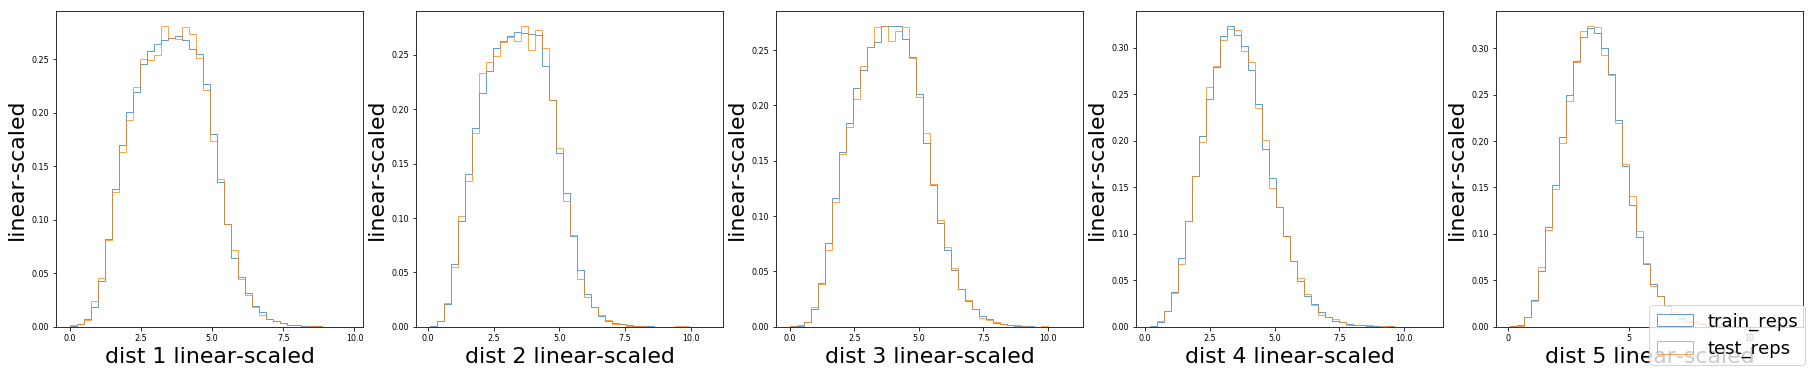

In [22]:
encoder, decoder = autoencoder.layers[1:]
train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), name="test_reps")
)
train_reps.plot([test_reps], cols=5, figsize=(25,5), fontsize=22, normed=1, bins=40)

In [36]:
def r_square_np(true, pred):
    SS_res = np.sum(np.square(true - pred), axis=1)
    SS_tot = np.sum(np.square(true - np.mean(true, axis=0)), axis=1)
    return 1. - SS_res/SS_tot

def get_errors(true, pred, out_name="errors", functions=["mse", "mae", r_square_np], names=[None, None, "r_square"]):
    import tensorflow as tf
    if names is None:
        names = ['err {}'.format(i) for i in range(len(functions))]
    
    functions_keep = []
    for i,f in enumerate(functions):
        if isinstance(f, str):
            fuse = getattr(keras.losses, f)
            functions_keep.append(fuse)
            names[i] = f
        else:
            functions_keep.append(f)
    
    raw = [func(true, pred) for func in functions_keep]
    raw = np.asarray(map(lambda x: K.eval(x) if isinstance(x, tf.Tensor) else x, raw)).T
    return utils.data_table(
        raw,
        headers=[str(f) for f in names],
        name=out_name
    )

def plot_error_ratios(main_error, compare_errors, metric='mse', bins= 40):
    import matplotlib.pyplot as plt
    ecounts, ebins = np.histogram(errors[metric], range=rng, bins=bins, normed=1)
    for e in errors_tagged:
        counts, bins = np.histogram(e[metric], range=rng, bins=bins, normed=1)
        ratio = counts.astype(float)/ecounts
        indx = np.where(counts*e.shape[0] > 10)
        print e.name, e.shape
        plt.plot(bins[:-1][indx], ratio[indx], label=e.name)
    #     print e.name,ratio
    plt.legend()
    plt.show()

errors = get_errors(norm.data, data_reconstructed_norm.data, "all errors")
tagged_norm = [train_raw.norm(t, **norm_args) for t in tagged]
# tagged_recon_norm = [utils.data_table(autoencoder.predict(t.data), name=t.name + "_norm", headers=t.headers) for t in tagged]
errors_tagged = [get_errors(t.data, autoencoder.predict(t.data), "error " + t.name.split("normed")[0].strip().strip("'")) for t in tagged_norm]

In [39]:
# errors.plot(
#     errors_tagged,
#     figsize=(20,8), 
#     bins=40,
#     rng=((0,0.1), (0, 0.25), (.85,1)),
#     fontsize=20, cols=3, 
#     figloc="upper center",
#     normed=True,
#     yscale="linear",
#     histtype="step",
#     alpha=1
# )
# errors.plot(
#     errors_tagged,
#     figsize=(20,8), 
#     bins=40,
#     rng=((0,0.3), (0, 0.5), (.5,1)),
#     fontsize=20, cols=3, 
#     figloc="upper center",
#     normed=True,
#     yscale="log",
#     histtype="step",
#     alpha=1
# )
# errors.plot(
#     errors_tagged,
#     figsize=(20,8), 
#     bins=20,
#     rng=((.1,0.3), (.12, 0.5), (.5,.9)),
#     fontsize=20, cols=3, 
#     figloc="upper center",
#     normed=True,
#     yscale="linear",
#     histtype="step",
#     alpha=1
# )